# Librairies

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

2024-11-13 10:16:34.478513: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-13 10:16:34.630911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 10:16:34.688581: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 10:16:34.704656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 10:16:34.809986: I tensorflow/core/platform/cpu_feature_guar

# Chargement de données

In [3]:
train_base_dir = '../Data/Data/train/'
clear_dir = os.path.join(train_base_dir, 'clear')
classes = ['clear', 'distorsion1', 'distorsion2', 'distorsion3','mvt1','mvt2','mvt3','gauss1','gauss2','gauss3','pixel1','pixel2','pixel3'] 

def verifier_et_lister_contenu(repertoire):
    if os.path.exists(repertoire):
        print(f"Le dossier '{repertoire}' contient les fichiers suivants :")
        for filename in os.listdir(repertoire):
            print(filename)
    else:
        print(f"Le dossier '{repertoire}' n'existe pas. Vérifiez le chemin.")

verifier_et_lister_contenu(clear_dir)


image_size = (224, 224)
batch_size = 64  


def charger_et_preparer_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)  
    img = tf.image.resize(img, image_size)  
    img = img / 255.0  
    return img


def charger_images_et_labels(repertoire, label):
    images_paths = [os.path.join(repertoire, filename) for filename in os.listdir(repertoire)]
    labels = [label] * len(images_paths)
    return images_paths, labels

clear_images, clear_labels = charger_images_et_labels(clear_dir, 0)

def create_tf_dataset(image_paths, labels, batch_size, shuffle_data=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda img_path, label: (charger_et_preparer_image(img_path), label), num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle_data:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


Le dossier '../Data/Data/train/clear' contient les fichiers suivants :
clear_34.jpg
clear_172.jpg
clear_1576.jpg
clear_1107.jpg
clear_38.jpg
clear_848.jpg
clear_1239.jpg
clear_992.jpg
clear_1462.jpg
clear_1297.jpg
clear_495.jpg
clear_259.jpg
clear_132.jpg
clear_62.jpg
clear_1096.jpg
clear_116.jpg
clear_1321.jpg
clear_286.jpg
clear_143.jpg
clear_1608.jpg
clear_1413.jpg
clear_847.jpg
clear_905.jpg
clear_190.jpg
clear_741.jpg
clear_511.jpg
clear_993.jpg
clear_1027.jpg
clear_391.jpg
clear_348.jpg
clear_770.jpg
clear_1482.jpg
clear_820.jpg
clear_1588.jpg
clear_1129.jpg
clear_937.jpg
clear_56.jpg
clear_367.jpg
clear_1318.jpg
clear_110.jpg
clear_1517.jpg
clear_1366.jpg
clear_1523.jpg
clear_201.jpg
clear_1403.jpg
clear_346.jpg
clear_600.jpg
clear_831.jpg
clear_506.jpg
clear_1190.jpg
clear_284.jpg
clear_1565.jpg
clear_1052.jpg
clear_556.jpg
clear_1474.jpg
clear_711.jpg
clear_661.jpg
clear_25.jpg
clear_1180.jpg
clear_35.jpg
clear_386.jpg
clear_48.jpg
clear_1460.jpg
clear_1323.jpg
clear_200.jpg
c

# Création du modèle

In [4]:


def create_model():
    model = keras.models.Sequential([
        keras.layers.Input((224, 224, 3)),
        keras.layers.Conv2D(32, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(2, activation='softmax')  # 2 classes
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [5]:
def process_model(model,obscur_dir) :

    obscur_images, obscur_labels = charger_images_et_labels(obscur_dir, 1)
    all_images = clear_images + obscur_images
    all_labels = clear_labels + obscur_labels
    X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.2, stratify=all_labels)



    train_dataset = create_tf_dataset(X_train, y_train,batch_size,True)
    validation_dataset = create_tf_dataset(X_val, y_val,batch_size,False)
    train_labels = np.concatenate([labels for _, labels in train_dataset], axis=0)
    val_labels = np.concatenate([labels for _, labels in validation_dataset], axis=0)
    print(f"Distribution des labels dans le jeu d'entraînement: {np.bincount(train_labels)}")
    print(f"Distribution des labels dans le jeu de validation: {np.bincount(val_labels)}")


    history = model.fit(
        train_dataset, 
        validation_data=validation_dataset,  
        epochs=5,   
        verbose=1    
    )

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Model accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    predictions = model.predict(validation_dataset)
    predictions = np.argmax(predictions, axis=1)
    true_labels = val_labels
    print(classification_report(true_labels, predictions))
    print(f"True labels: {true_labels[:10]}")
    print(f"Predictions: {predictions[:10]}")
    print(f"Shape of true_labels: {true_labels.shape}")
    print(f"Shape of predictions: {predictions.shape}")

    cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
    class_names = [str(0),str(1)]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig("matrice.png")
    plt.show()

    

# Distorsion

Distribution des labels dans le jeu d'entraînement: [1289 1291]
Distribution des labels dans le jeu de validation: [322 323]
Epoch 1/5


2024-11-13 10:07:09.170400: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 728ms/step - accuracy: 0.5198 - loss: 1.8584 - val_accuracy: 0.7442 - val_loss: 0.5112
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 716ms/step - accuracy: 0.7409 - loss: 0.4314 - val_accuracy: 0.7736 - val_loss: 0.4531
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 716ms/step - accuracy: 0.7983 - loss: 0.3512 - val_accuracy: 0.8357 - val_loss: 0.2913
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 720ms/step - accuracy: 0.8872 - loss: 0.2378 - val_accuracy: 0.8775 - val_loss: 0.2487
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 721ms/step - accuracy: 0.9237 - loss: 0.1729 - val_accuracy: 0.8977 - val_loss: 0.2261


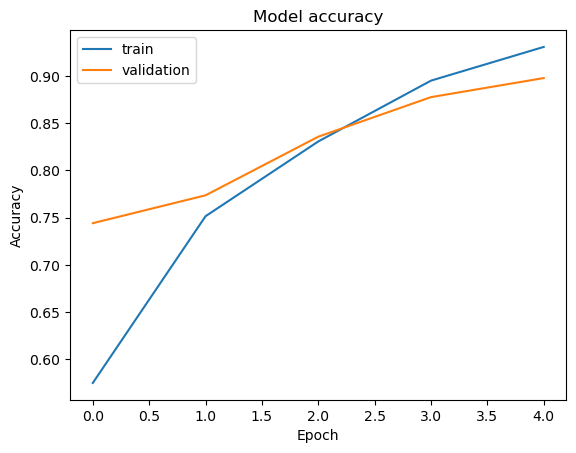

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       322
           1       0.84      0.98      0.91       323

    accuracy                           0.90       645
   macro avg       0.91      0.90      0.90       645
weighted avg       0.91      0.90      0.90       645

True labels: [0 1 0 1 0 0 0 1 0 0]
Predictions: [0 1 0 1 0 0 0 1 0 0]
Shape of true_labels: (645,)
Shape of predictions: (645,)


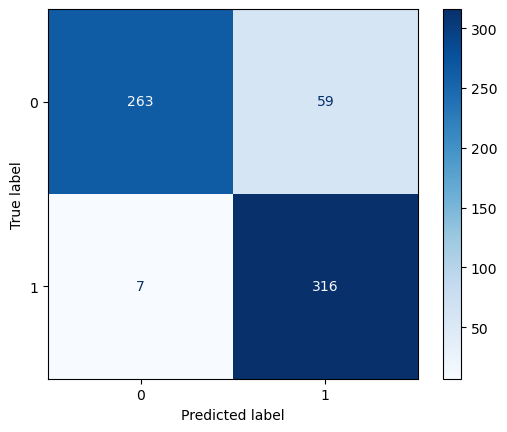

In [7]:
# DIstorsion1

model=create_model()
distorsion1_dir = os.path.join(train_base_dir, 'distorsion1')
process_model(model,distorsion1_dir)

# Sauvegarde du modèle
# model.save('model_dist1.keras') #modele lourd pour push sur git





2024-11-13 10:16:55.946570: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Distribution des labels dans le jeu d'entraînement: [1288 1292]
Distribution des labels dans le jeu de validation: [323 323]
Epoch 1/5


2024-11-13 10:16:56.537278: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 722ms/step - accuracy: 0.6149 - loss: 1.1621 - val_accuracy: 0.9226 - val_loss: 0.2458
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 711ms/step - accuracy: 0.9221 - loss: 0.1978 - val_accuracy: 0.9923 - val_loss: 0.0500
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 707ms/step - accuracy: 0.9947 - loss: 0.0229 - val_accuracy: 0.9907 - val_loss: 0.0206
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 711ms/step - accuracy: 0.9988 - loss: 0.0064 - val_accuracy: 0.9985 - val_loss: 0.0082
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 29s 715ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9985 - val_loss: 0.0138


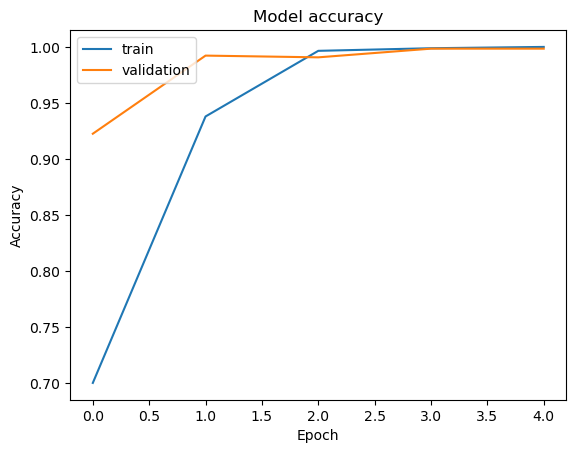

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       323
           1       1.00      1.00      1.00       323

    accuracy                           1.00       646
   macro avg       1.00      1.00      1.00       646
weighted avg       1.00      1.00      1.00       646

True labels: [0 1 1 0 0 0 1 0 1 0]
Predictions: [0 1 1 0 0 0 1 0 1 0]
Shape of true_labels: (646,)
Shape of predictions: (646,)


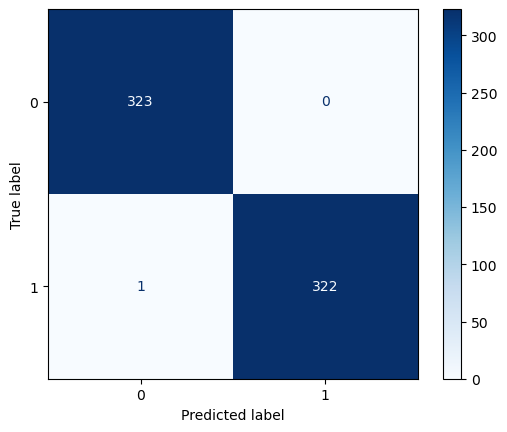

In [6]:
# DIstorsion2

model=create_model()
distorsion2_dir = os.path.join(train_base_dir, 'distorsion2')
process_model(model,distorsion2_dir)
# Sauvegarde du modèle
# model.save('model_dist2.keras') #modele lourd pour push sur git





Distribution des labels dans le jeu d'entraînement: [1289 1348]
Distribution des labels dans le jeu de validation: [322 338]
Epoch 1/5


2024-11-13 10:19:37.322639: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 726ms/step - accuracy: 0.5793 - loss: 3.3925 - val_accuracy: 0.7470 - val_loss: 0.3679
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 720ms/step - accuracy: 0.8760 - loss: 0.2468 - val_accuracy: 0.9909 - val_loss: 0.0892
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 721ms/step - accuracy: 0.9677 - loss: 0.0982 - val_accuracy: 0.9985 - val_loss: 0.0161
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 723ms/step - accuracy: 0.9997 - loss: 0.0134 - val_accuracy: 0.9985 - val_loss: 0.0208
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 726ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 0.0045


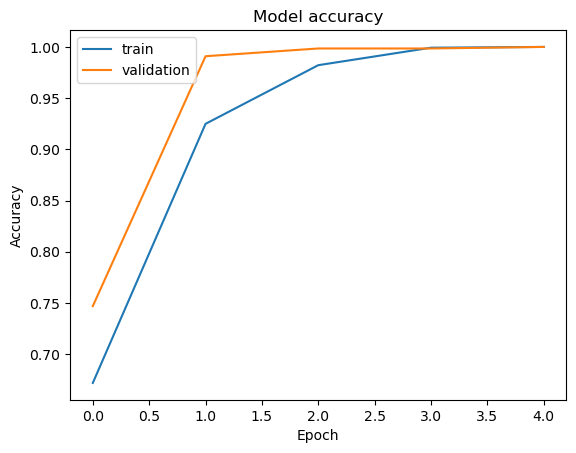

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       322
           1       1.00      1.00      1.00       338

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660

True labels: [0 1 0 1 1 0 0 0 1 1]
Predictions: [0 1 0 1 1 0 0 0 1 1]
Shape of true_labels: (660,)
Shape of predictions: (660,)


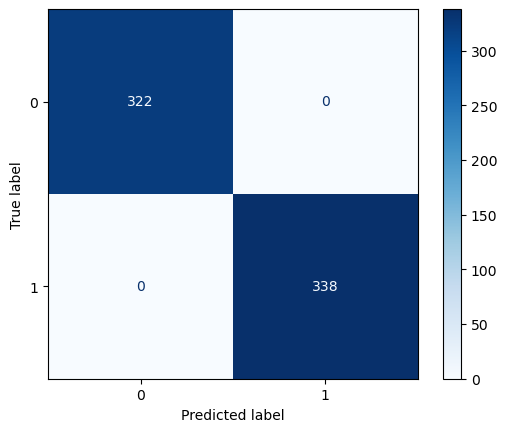

In [7]:
# DIstorsion3

model=create_model()
distorsion3_dir = os.path.join(train_base_dir, 'distorsion3')
process_model(model,distorsion3_dir)

# Sauvegarde du modèle
# model.save('model_dist3.keras') #modele lourd pour push sur git




# Flou Mouvement

In [1]:
# Mvt1

model=create_model()
mvt1_dir = os.path.join(train_base_dir, 'mvt1')
process_model(model,mvt1_dir)

# Sauvegarde du modèle
# model.save('model_mvt1.keras') #modele lourd pour push sur git


NameError: name 'create_model' is not defined

In [ ]:
# Mvt2

model=create_model()
mvt2_dir = os.path.join(train_base_dir, 'mvt2')
process_model(model,mvt2_dir)
# Sauvegarde du modèle
# model.save('model_mvt2.keras') #modele lourd pour push sur git


In [ ]:
# Mvt3

model=create_model()
mvt3_dir = os.path.join(train_base_dir, 'mvt3')
process_model(model,mvt3_dir)
# Sauvegarde du modèle
# model.save('model_mvt3.keras') #modele lourd pour push sur git



# Flou gaussien

In [ ]:
# Gauss1

model=create_model()
gauss1_dir = os.path.join(train_base_dir, 'gauss1')
process_model(model,gauss1_dir)
# Sauvegarde du modèle
# model.save('model_gauss1.keras') #modele lourd pour push sur git



In [ ]:
# Gauss2

model=create_model()
gauss2_dir = os.path.join(train_base_dir, 'gauss2')
process_model(model,gauss2_dir)
# Sauvegarde du modèle
# model.save('model_gauss2.keras') #modele lourd pour push sur git


Distribution des labels dans le jeu d'entraînement: [1289 1342]
Distribution des labels dans le jeu de validation: [322 336]
Epoch 1/5


2024-11-13 09:26:42.848730: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-13 09:26:42.925015: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 722ms/step - accuracy: 0.5264 - loss: 3.6596 - val_accuracy: 0.7888 - val_loss: 0.6127
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 714ms/step - accuracy: 0.8238 - loss: 0.4562 - val_accuracy: 0.9909 - val_loss: 0.0648
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 710ms/step - accuracy: 0.9875 - loss: 0.0553 - val_accuracy: 0.9939 - val_loss: 0.0322
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 729ms/step - accuracy: 0.9982 - loss: 0.0153 - val_accuracy: 0.9909 - val_loss: 0.0300
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 737ms/step - accuracy: 0.9930 - loss: 0.0148 - val_accuracy: 0.9939 - val_loss: 0.0197


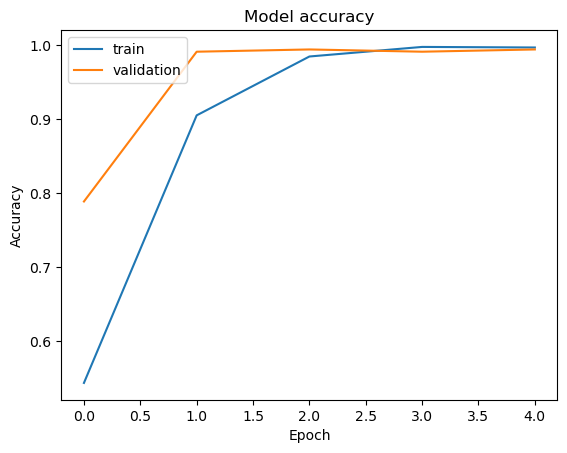

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       322
           1       0.99      1.00      0.99       336

    accuracy                           0.99       658
   macro avg       0.99      0.99      0.99       658
weighted avg       0.99      0.99      0.99       658

True labels: [1 1 1 1 1 1 1 1 1 1]
Predictions: [1 1 1 1 1 1 1 1 1 1]
Shape of true_labels: (658,)
Shape of predictions: (658,)


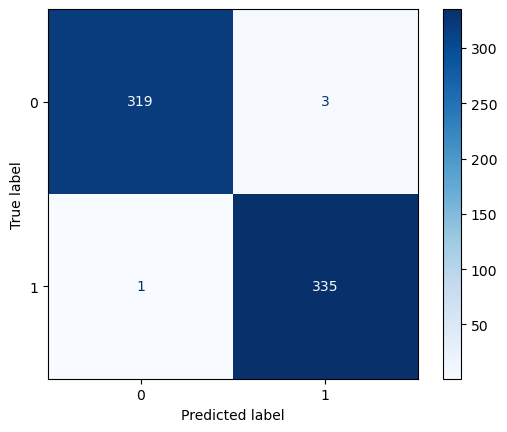

In [6]:
# Gauss3

model=create_model()
gauss3_dir = os.path.join(train_base_dir, 'gauss3')
process_model(model,gauss3_dir)
# Sauvegarde du modèle
# model.save('model_gauss3.keras') #modele lourd pour push sur git


# Pixelisation

In [ ]:
# Pixel1

model=create_model()
pixel1_dir = os.path.join(train_base_dir, 'pixel1')
process_model(model,pixel1_dir)
# Sauvegarde du modèle
# model.save('model_pixel1.keras') #modele lourd pour push sur git


In [ ]:
# Pixel2

model=create_model()
pixel2_dir = os.path.join(train_base_dir, 'pixel1')
process_model(model,pixel2_dir)
# Sauvegarde du modèle
# model.save('model_pixel2.keras') #modele lourd pour push sur git

In [ ]:
# Pixel3

model=create_model()
pixel3_dir = os.path.join(train_base_dir, 'pixel3')
process_model(model,pixel3_dir)
# Sauvegarde du modèle
# model.save('model_pixel3.keras') #modele lourd pour push sur git